In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, CollapsedGibbsLDA, PyroLDA

clear_output()

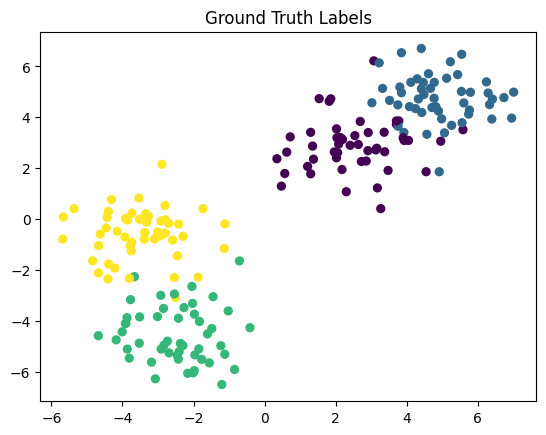

In [424]:
N_SAMPLES = 200
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

In [414]:
from scipy.cluster.vq import kmeans, vq

In [425]:
k = 15
iters = 100
features = np.reshape(X, (200*100,))
codebook, variance = kmeans(features, k, iters)
codebook.shape

(15,)

In [426]:
idx, _ = vq(features, codebook)
Y = idx.reshape(200, 100)
Y

array([[12,  5,  3, ..., 12,  4, 10],
       [ 1,  0, 11, ..., 12,  1,  2],
       [11, 11,  8, ...,  4,  5,  4],
       ...,
       [ 1,  0, 14, ..., 12, 12,  2],
       [ 4,  3,  1, ..., 11,  1, 14],
       [10, 11,  9, ...,  3,  1, 12]], dtype=int32)

100%|██████████| 200/200 [01:33<00:00,  2.13it/s]

Score: 0.895


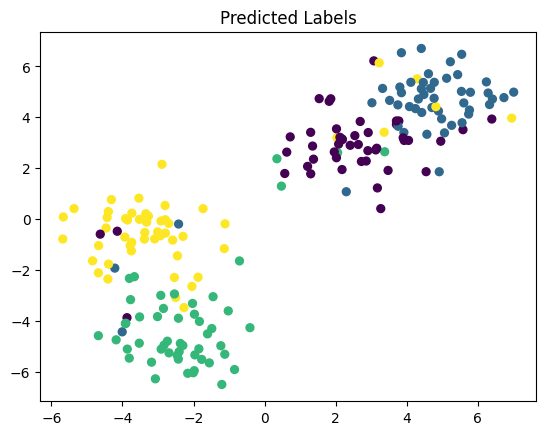

In [427]:
N_STEPS = 200

# pyro.clear_param_store()
model = GibbsLDA(N_TOPICS).fit(Y, N_STEPS)
# model = PyroLDA(N_TOPICS).fit(torch.tensor(Y).T, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

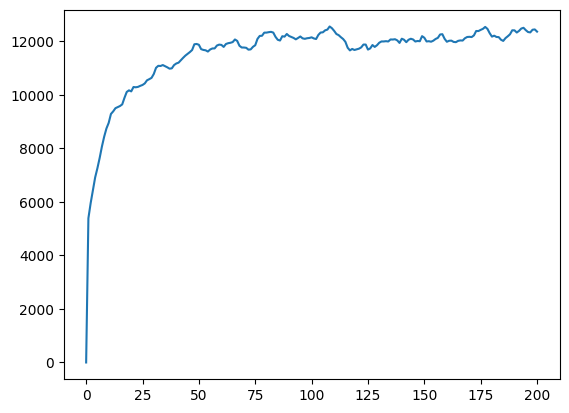

In [428]:
y = model.likelihood_log_
# y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);

In [346]:
from sklearn.decomposition import LatentDirichletAllocation

Score: 1.0


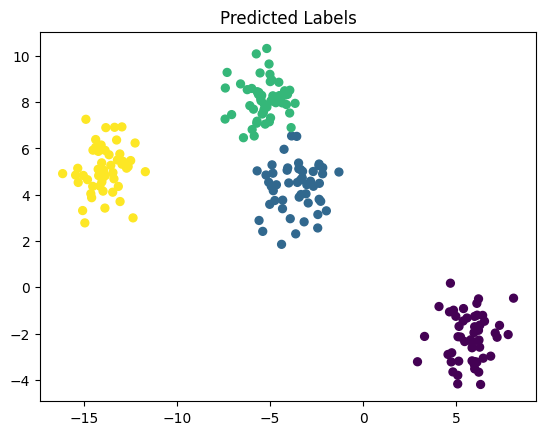

In [350]:
model = LatentDirichletAllocation(N_TOPICS)
Y_labels, score = util.evaluate(X_labels, model.fit_transform(Y).argmax(-1))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

In [160]:
k = 4
iters = 100
codebook, variance = kmeans(markers, k, iters)
codebook.shape

(4, 98)

In [171]:
idx, _ = vq(markers, codebook)
idx

array([2, 3, 3, 1, 0, 3, 1, 2, 2, 2, 3, 2, 1, 0, 3, 3, 3, 1, 3, 0, 1, 0,
       3, 2, 0, 2, 0, 0, 1, 3, 0, 2, 0, 3, 2, 3, 0, 0, 2, 2, 1, 3, 3, 2,
       2, 0, 3, 0, 0, 2, 0, 3, 0, 2, 2, 1, 0, 0, 3, 3, 1, 1, 1, 0, 1, 2,
       2, 1, 1, 0, 2, 2, 2, 2, 3, 0, 1, 1, 2, 0, 3, 1, 1, 3, 3, 0, 0, 2,
       1, 1, 0, 1, 1, 1, 1, 3, 3, 2, 1, 0, 3, 1, 2, 0, 2, 1, 2, 3, 1, 2,
       2, 3, 0, 3, 2, 3, 2, 1, 0, 2, 0, 3, 3, 2, 3, 1, 1, 3, 0, 3, 0, 1,
       3, 0, 2, 1, 0, 0, 3, 3, 2, 3, 2, 1, 0, 1, 1, 3, 2, 0, 3, 2, 1, 0,
       1, 3, 3, 2, 1, 3, 3, 0, 1, 2, 0, 0, 3, 1, 0, 1, 1, 0, 3, 2, 2, 1,
       0, 0, 1, 3, 3, 2, 1, 3, 3, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 0, 1,
       0, 2], dtype=int32)

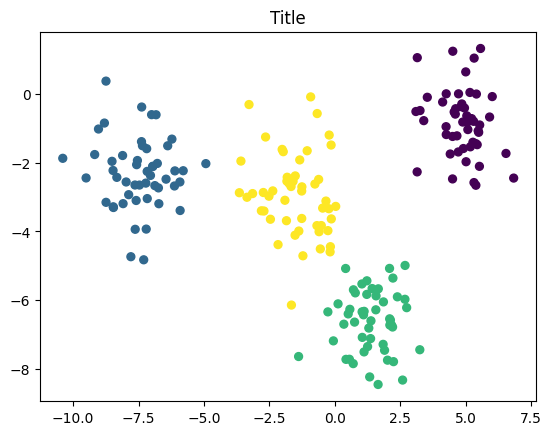

In [172]:
util.visualize_data(X, idx)

In [162]:
data = np.empty_like(X)
data[:, :2] = X[:, :2]
data[:, 2:] = codebook[idx]
data.shape

(200, 100)

In [163]:
vocab = np.unique(data)
vocab

array([-1.97532350e+01, -1.60810444e+01, -1.49427391e+01, -1.40351391e+01,
       -1.39334853e+01, -1.39048655e+01, -1.17116449e+01, -1.17038084e+01,
       -1.09796397e+01, -1.09656674e+01, -1.03969211e+01, -1.03215351e+01,
       -1.02134760e+01, -9.96137687e+00, -9.93426191e+00, -9.75875667e+00,
       -9.75012955e+00, -9.73511901e+00, -9.70766661e+00, -9.50559881e+00,
       -9.40665663e+00, -9.23741349e+00, -9.21260038e+00, -9.17763459e+00,
       -9.07860276e+00, -9.04530058e+00, -9.03217788e+00, -8.97740566e+00,
       -8.97729228e+00, -8.80582264e+00, -8.77453983e+00, -8.74592201e+00,
       -8.74348978e+00, -8.72440524e+00, -8.58504857e+00, -8.57416238e+00,
       -8.51588440e+00, -8.47589680e+00, -8.46985445e+00, -8.46812979e+00,
       -8.46087410e+00, -8.45415999e+00, -8.33159436e+00, -8.32551864e+00,
       -8.24232520e+00, -8.23429241e+00, -8.18298767e+00, -8.11097153e+00,
       -8.09241999e+00, -7.97572571e+00, -7.96562110e+00, -7.95069326e+00,
       -7.92305344e+00, -

In [164]:
Y = np.zeros_like(data, dtype=np.int32)
for idx, word in enumerate(vocab):
    Y[np.where(data == word)] = idx
Y

array([[567,  41,  38, ..., 594, 689, 767],
       [466, 239, 741, ..., 584, 546, 786],
       [276, 234, 741, ..., 584, 546, 786],
       ...,
       [137, 322, 774, ..., 401, 649, 656],
       [628, 540, 154, ..., 176, 760, 603],
       [536, 126,  38, ..., 594, 689, 767]], dtype=int32)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

Score: 1.0


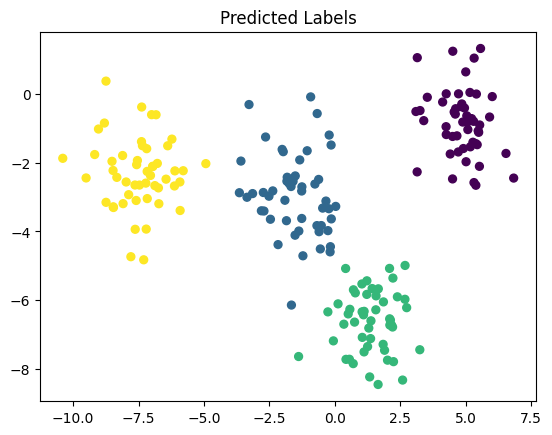

In [165]:
N_STEPS = 10

model = GibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

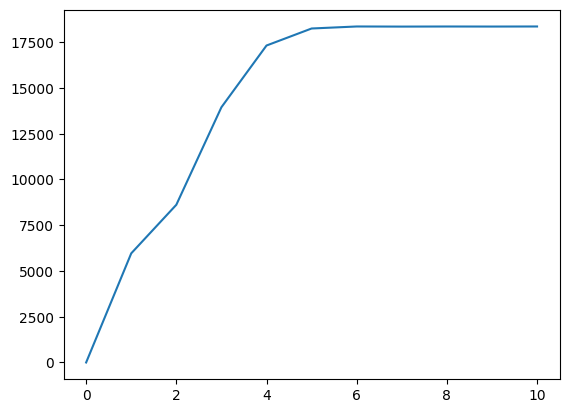

In [166]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

In [107]:
def psi(x):
    if x <= 1e-6:
        return -np.euler_gamma - 1./x
    result = 0
    while x < 6:
        result -= 1./x
        x += 1
    r = 1./x
    result += np.log(x) - .5*r
    r = r*r
    result -= r*((1./12.) - r*((1./120.) - r*(1./252.)))
    return result

def dirichlet_expectation_2d(x):
    n_docs, n_words = x.shape
    d_exp = np.empty_like(x)
    for i in range(n_docs):
        row_total = 0
        for j in range(n_words):
            row_total += x[i, j]
        psi_row_total = psi(row_total)
        for j in range(n_words):
            d_exp[i, j] = psi(x[i, j]) - psi_row_total
    return d_exp

def dirichlet_expectation_1d(doc_topic, doc_topic_prior, out):
    size = doc_topic.shape[0]
    total = 0.
    for i in range(size):
        dt = doc_topic[i] + doc_topic_prior
        doc_topic[i] = dt
        total += dt
    psi_total = psi(total)
    for i in range(size):
        out[i] = np.exp(psi(doc_topic[i]) - psi_total)

In [108]:
init_gamma = 100.
init_var = 1./init_gamma
components = np.random.gamma(init_gamma, init_var, (N_TOPICS, N_FEATURES))
exp_dirichlet_component_ = np.exp(dirichlet_expectation_2d(components))

In [120]:
n_docs, n_words = X.shape
doc_topic_prior = 1./N_TOPICS
doc_topic_dist = np.ones((n_docs, N_TOPICS), dtype=X.dtype)
exp_doc_topic = np.exp(dirichlet_expectation_2d(doc_topic_dist))
suff_stats = np.zeros(exp_dirichlet_component_.shape, dtype=X.dtype)
eps = np.finfo(X.dtype).eps
for idx_d in range(n_docs):
    ids = np.nonzero(X[idx_d, :])[0]
    counts = X[idx_d, ids]
    doc_topic_d = doc_topic_dist[idx_d, :]
    exp_doc_topic_d = exp_doc_topic[idx_d, :].copy()
    exp_topic_word_d = exp_dirichlet_component_[:, ids]
    for _ in range(100):
        last_d = doc_topic_d
        norm_phi = np.dot(exp_doc_topic_d, exp_topic_word_d) + eps
        doc_topic_d = exp_doc_topic_d*np.dot(counts/norm_phi, exp_topic_word_d.T)
        dirichlet_expectation_1d(doc_topic_d, doc_topic_prior, exp_doc_topic_d)
    doc_topic_dist[idx_d, :] = doc_topic_d
    norm_phi = np.dot(exp_doc_topic_d, exp_topic_word_d) + eps
    suff_stats[:, ids] += np.outer(exp_doc_topic_d, counts/norm_phi)
suff_stats *= exp_dirichlet_component_

In [111]:
doc_topic_dist.shape

(200, 4)

In [122]:
components.shape

(4, 100)

100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]

Score: 0.815


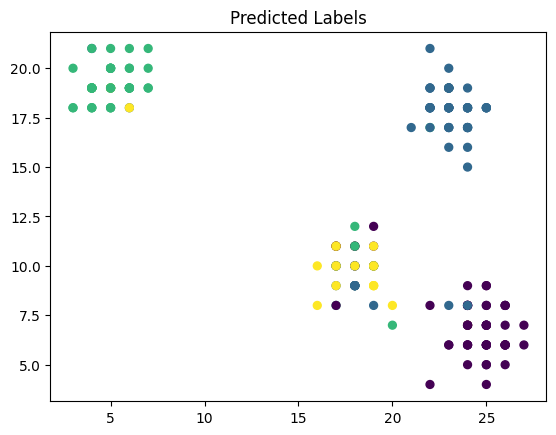

In [75]:
N_STEPS = 1000

model = GibbsLDA(N_TOPICS).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

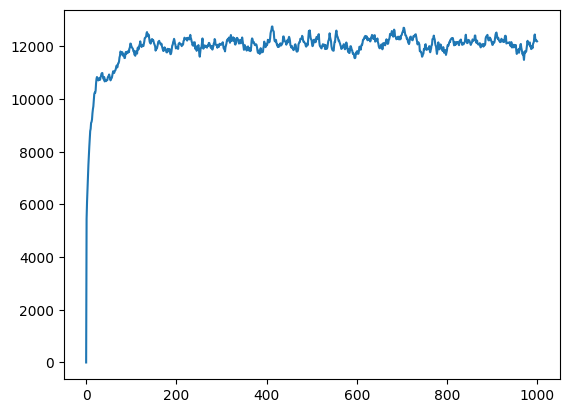

In [76]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s]

Score: 0.805


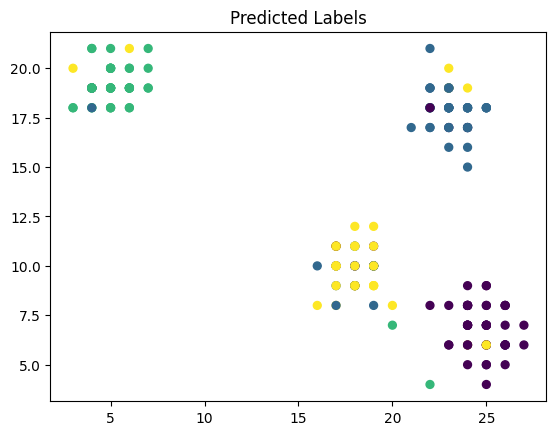

In [77]:
N_STEPS = 1000

model = CollapsedGibbsLDA(N_TOPICS).fit(torch.tensor(X), N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

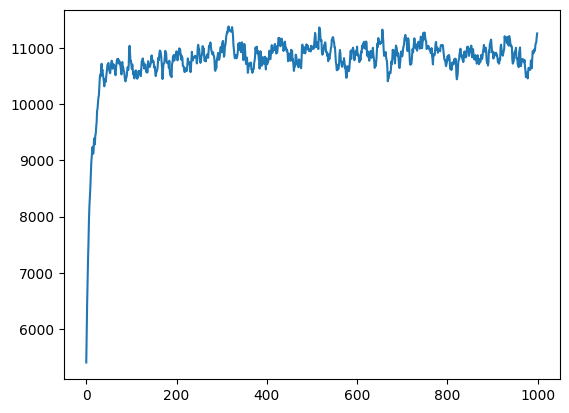

In [78]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [00:08<00:00, 115.09it/s]


Score: 0.84


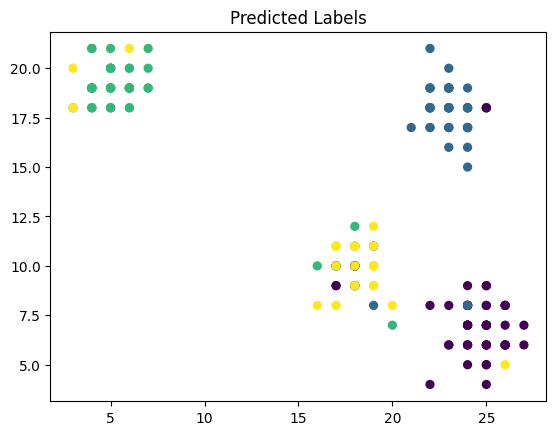

In [79]:
N_STEPS = 1000

pyro.clear_param_store()
Y = torch.tensor(X).T
model = PyroLDA(N_TOPICS, batch_size=100).fit(Y, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(Y))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

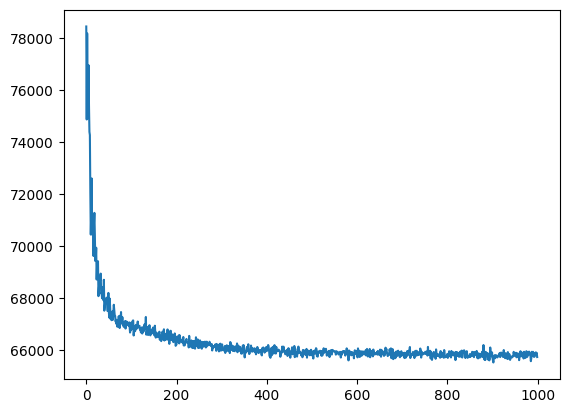

In [80]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);